# Лабораторная работа: Интерполяционные полиномы в структурах и алгоритмах данных



## 1. Введение
Интерполяция — это способ нахождения значения функции в точке по известным значениям в других точках.


## 2. Структуры данных
Изучите классы для хранения узлов и таблицы разделённых разностей.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


class InterpolationNode:
    def __init__(self, x, y):
        self.x = x
        self.y = y


class DividedDifferencesTable:
    def __init__(self, nodes):
        self.n = len(nodes)
        self.x = np.array([node.x for node in nodes])
        self.y = np.array([node.y for node in nodes])
        self.table = self._compute_table()

    def _compute_table(self):
        n = self.n
        F = np.zeros((n, n))
        F[:, 0] = self.y
        for j in range(1, n):
            for i in range(n - j):
                F[i][j] = (F[i + 1][j - 1] - F[i][j - 1]) / (self.x[i + j] - self.x[i])
        return F

    def get_coefs(self):
        return self.table[0, :]


## 3. Реализация полиномов
### Проанализируйте код вычисления полиномов Ньютона/Стирлинга/Лагранжа

Полином Ньютона:

In [2]:
class NewtonPolynomial:
    def __init__(self, nodes):
        self.table = DividedDifferencesTable(nodes)
        self.xnodes = self.table.x
        self.coefs = self.table.get_coefs()
    def evaluate(self, x):
        n = len(self.coefs)
        res = self.coefs[0]
        for i in range(1, n):
            prod = 1
            for j in range(i):
                prod *= (x - self.xnodes[j])
            res += self.coefs[i]*prod
        return res


Полином Стирлинга

In [3]:
from math import factorial
class StirlingPolynomial:
    def __init__(self, nodes):
        self.nodes = sorted(nodes, key=lambda node: node.x)
        self.n = len(nodes)
        self.h = self.nodes[1].x - self.nodes[0].x
        for i in range(self.n-1):
            assert abs(self.nodes[i+1].x - self.nodes[i].x - self.h) < 1e-12, 'Узлы должны быть равноотстоящими'
        assert self.n % 2 == 1, 'Число узлов должно быть нечетным'
        self.m = self.n // 2
        self.x0 = self.nodes[self.m].x
        F = np.zeros((self.n, self.n))
        F[:,0] = np.array([node.y for node in self.nodes])
        for j in range(1, self.n):
            for i in range(self.n-j):
                F[i][j] = F[i+1][j-1] - F[i][j-1]
        self.F = F
    def evaluate(self, x):
        t = (x - self.x0)/self.h
        res = self.F[self.m][0]
        prod = 1
        for k in range(1, self.n):
            prod *= (t - (k-1)//2) if k%2==1 else (t + k//2)
            coeff = self.F[self.m - k//2][k] / factorial(k)
            res += coeff * prod
        return res


Полином Ланграджа

In [4]:
class LagrangePolynomial:
    def __init__(self, nodes):
        self.nodes = nodes
        self.xnodes = [x for x, y in nodes]
        self.ynodes = [y for x, y in nodes]

    def evaluate(self, x):
        res = 0
        n = len(self.nodes)
        for i in range(n):
            term = self.ynodes[i]
            for j in range(n):
                if j != i:
                    term *= (x - self.xnodes[j]) / (self.xnodes[i] - self.xnodes[j])
            res += term
        return res


## 4. Сравнительный анализ методов
Создайте тестовую функцию, которая будет сравнивать ошибки и время выполнения

In [5]:
import time
import numpy as np

def compare_interpolation_methods(nodes, test_points, true_function):

    results = {}
    
    start_time = time.time()
    newton = NewtonPolynomial(nodes)
    newton_values = np.array([newton.evaluate(x) for x in test_points])
    newton_time = time.time() - start_time
    
    start_time = time.time()
    lagrange = LagrangePolynomial(nodes)
    lagrange_values = np.array([lagrange.evaluate(x) for x in test_points])
    lagrange_time = time.time() - start_time
    
    stirling_time = 0
    stirling_values = None
    if len(nodes) % 2 == 1 and np.allclose(np.diff([node.x for node in nodes]), 
                                           np.diff([node.x for node in nodes])[0]):
        start_time = time.time()
        stirling = StirlingPolynomial(nodes)
        stirling_values = np.array([stirling.evaluate(x) for x in test_points])
        stirling_time = time.time() - start_time
    
    true_values = np.array([true_function(x) for x in test_points])

    newton_error = np.sqrt(np.mean((newton_values - true_values) ** 2))
    lagrange_error = np.sqrt(np.mean((lagrange_values - true_values) ** 2))
    
    if stirling_values is not None:
        stirling_error = np.sqrt(np.mean((stirling_values - true_values) ** 2))
    else:
        stirling_error = None

    results = {
        'Newton': {'time': newton_time, 'error': newton_error, 'values': newton_values},
        'Lagrange': {'time': lagrange_time, 'error': lagrange_error, 'values': lagrange_values},
    }
    
    if stirling_values is not None:
        results['Stirling'] = {'time': stirling_time, 'error': stirling_error, 'values': stirling_values}
    
    return results

## 5. Визуализация результатов
Используйте функцию синуса для визуализации результатов. Необходимо вывести узлы, оригинальную функцию и полиномы. Пример:


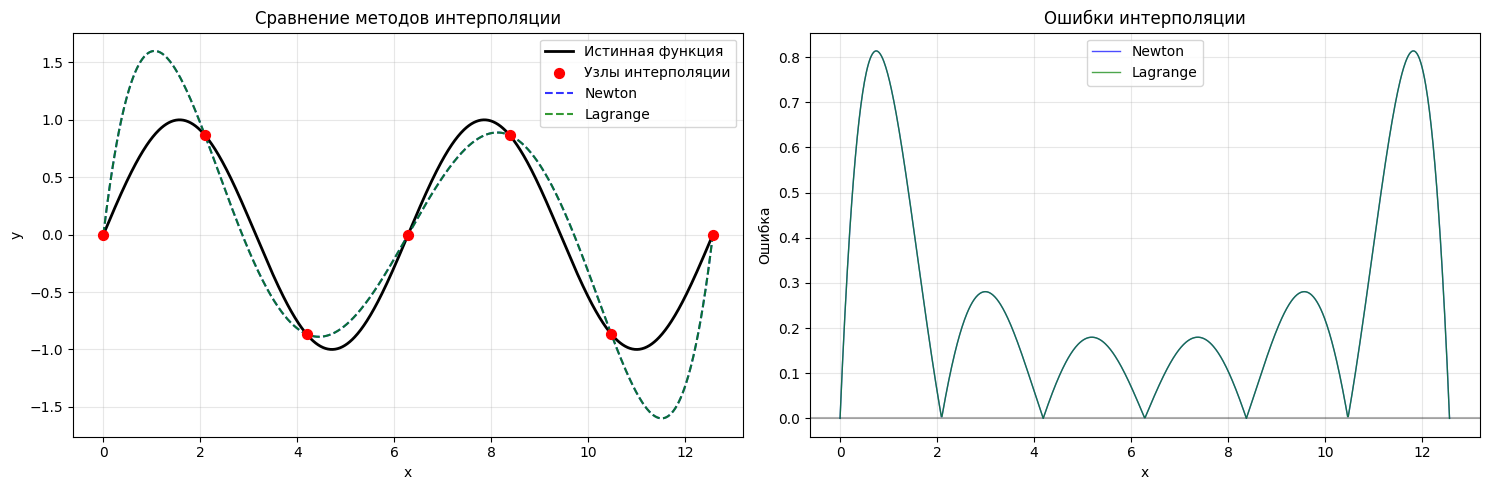

In [6]:
def visualize_interpolation(nodes, interpolation_methods, true_function, x_range):

    x_vals = np.linspace(x_range[0], x_range[1], 1000)
    y_true = true_function(x_vals)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(x_vals, y_true, 'k-', label='Истинная функция', linewidth=2)

    x_nodes = [node.x for node in nodes]
    y_nodes = [node.y for node in nodes]
    axes[0].scatter(x_nodes, y_nodes, color='red', s=50, zorder=5, label='Узлы интерполяции')

    colors = ['b', 'g', 'r']
    for (method_name, method), color in zip(interpolation_methods.items(), colors):
        y_interp = [method.evaluate(x) for x in x_vals]
        axes[0].plot(x_vals, y_interp, color + '--', 
                    label=f'{method_name}', alpha=0.8, linewidth=1.5)
    
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].set_title('Сравнение методов интерполяции')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel('x')
    axes[1].set_ylabel('Ошибка')
    axes[1].set_title('Ошибки интерполяции')
    axes[1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    for (method_name, method), color in zip(interpolation_methods.items(), colors):
        y_interp = [method.evaluate(x) for x in x_vals]
        error = np.abs(np.array(y_interp) - y_true)
        axes[1].plot(x_vals, error, color + '-', 
                    label=f'{method_name}', alpha=0.7, linewidth=1)
    
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def test_sin():
    n_nodes = 7
    x_nodes = np.linspace(0, 4*np.pi, n_nodes)
    y_nodes = np.sin(x_nodes)
    nodes = [InterpolationNode(x, y) for x, y in zip(x_nodes, y_nodes)]

    newton = NewtonPolynomial(nodes)
    lagrange = LagrangePolynomial([(node.x, node.y) for node in nodes])

    visualize_interpolation(
        nodes, 
        {'Newton': newton, 'Lagrange': lagrange},
        np.sin,
        [0, 4*np.pi]
    )

test_sin()


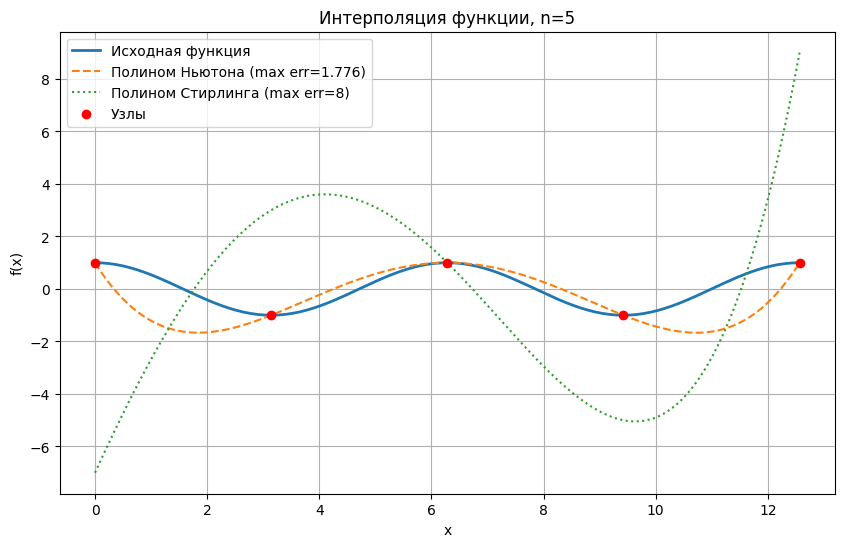

## 6. Задания для самостоятельной работы
### 1. Проведите эксперимент с разным числом узлов (5, 7, 9, 11...) и сравните результаты








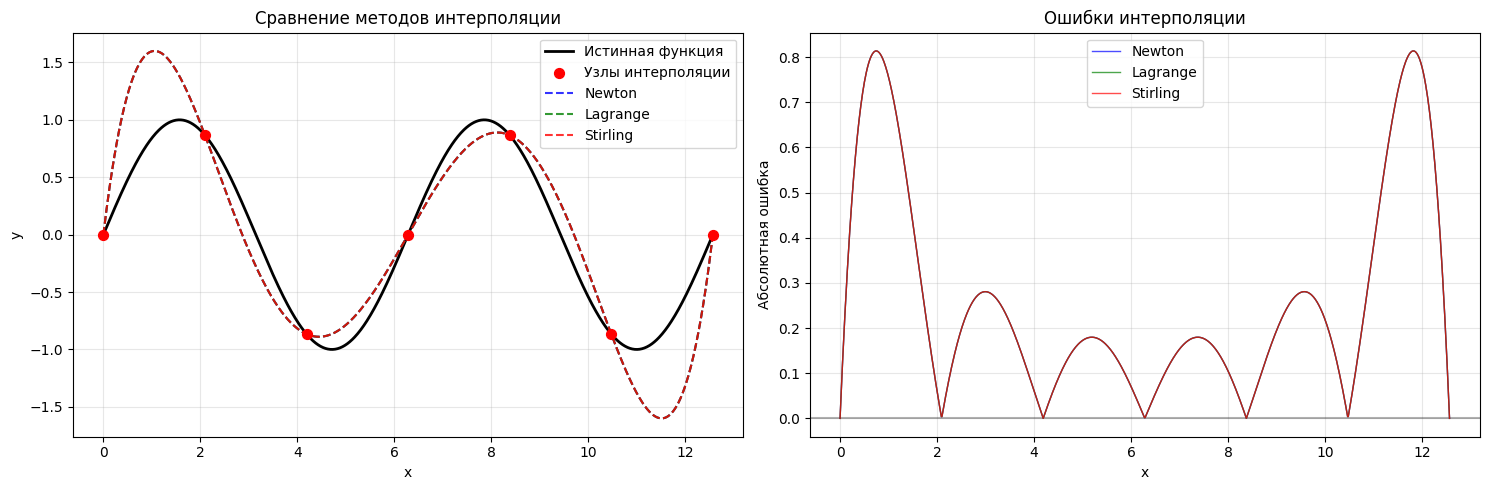

In [7]:
def compare_interpolation_methods(nodes, test_points, true_function):
    results = {}
    
    start_time = time.time()
    newton = NewtonPolynomial(nodes)
    newton_values = np.array([newton.evaluate(x) for x in test_points])
    newton_time = time.time() - start_time

    start_time = time.time()
    lagrange = LagrangePolynomial([(node.x, node.y) for node in nodes])
    lagrange_values = np.array([lagrange.evaluate(x) for x in test_points])
    lagrange_time = time.time() - start_time

    stirling_time = 0
    stirling_values = None
    if len(nodes) % 2 == 1:
        x_nodes = [node.x for node in nodes]
        diffs = np.diff(x_nodes)
        if np.allclose(diffs, diffs[0]):
            try:
                start_time = time.time()
                stirling = StirlingPolynomial(nodes)
                stirling_values = np.array([stirling.evaluate(x) for x in test_points])
                stirling_time = time.time() - start_time
            except Exception as e:
                print(f"Ошибка при создании полинома Стирлинга: {e}")

    true_values = np.array([true_function(x) for x in test_points])

    newton_error = np.sqrt(np.mean((newton_values - true_values) ** 2))
    lagrange_error = np.sqrt(np.mean((lagrange_values - true_values) ** 2))
    
    results = {
        'Newton': {'time': newton_time, 'error': newton_error, 'values': newton_values},
        'Lagrange': {'time': lagrange_time, 'error': lagrange_error, 'values': lagrange_values},
    }
    
    if stirling_values is not None:
        stirling_error = np.sqrt(np.mean((stirling_values - true_values) ** 2))
        results['Stirling'] = {'time': stirling_time, 'error': stirling_error, 'values': stirling_values}
    
    return results

def visualize_interpolation(nodes, interpolation_methods, true_function, x_range):
    x_vals = np.linspace(x_range[0], x_range[1], 1000)
    y_true = true_function(x_vals)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(x_vals, y_true, 'k-', label='Истинная функция', linewidth=2)

    x_nodes = [node.x for node in nodes]
    y_nodes = [node.y for node in nodes]
    axes[0].scatter(x_nodes, y_nodes, color='red', s=50, zorder=5, label='Узлы интерполяции')

    colors = ['b', 'g', 'r', 'm']
    methods_list = list(interpolation_methods.items())
    
    for idx, (method_name, method) in enumerate(methods_list):
        y_interp = np.array([method.evaluate(x) for x in x_vals])
        axes[0].plot(x_vals, y_interp, colors[idx] + '--', 
                    label=f'{method_name}', alpha=0.8, linewidth=1.5)
    
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].set_title('Сравнение методов интерполяции')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel('x')
    axes[1].set_ylabel('Абсолютная ошибка')
    axes[1].set_title('Ошибки интерполяции')
    axes[1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    for idx, (method_name, method) in enumerate(methods_list):
        y_interp = np.array([method.evaluate(x) for x in x_vals])
        error = np.abs(y_interp - y_true)
        axes[1].plot(x_vals, error, colors[idx] + '-', 
                    label=f'{method_name}', alpha=0.7, linewidth=1)
    
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def test_sin():
    n_nodes = 7
    x_nodes = np.linspace(0, 4*np.pi, n_nodes)
    y_nodes = np.sin(x_nodes)
    nodes = [InterpolationNode(x, y) for x, y in zip(x_nodes, y_nodes)]

    newton = NewtonPolynomial(nodes)
    lagrange = LagrangePolynomial([(node.x, node.y) for node in nodes])
    
    methods = {'Newton': newton, 'Lagrange': lagrange}

    if n_nodes % 2 == 1:
        try:
            stirling = StirlingPolynomial(nodes)
            methods['Stirling'] = stirling
        except Exception as e:
            print(f"Полином Стирлинга не создан: {e}")
    visualize_interpolation(
        nodes, 
        methods,
        np.sin,
        [0, 4*np.pi]
    )

test_sin()

### 2.Протестируйте полиномы на формулах:


$$
\begin{aligned}
&\text{Синус:} \quad f_1(x) = \sin(x), \quad x \in [0, 4\pi] \\
&\text{Косинус:} \quad f_2(x) = \cos(x), \quad x \in [0, 4\pi] \\
&\text{Функция Рунге:} \quad f_3(x) = \frac{1}{1 + 25x^2}, \quad x \in [-1, 1] \\
&\text{Кусочно-линейная (пилообразная):} \quad f_4(x) = x - 5\left\lfloor \frac{x}{5} \right\rfloor, \quad x \in [0, 20] \\
&\text{Функция с быстрыми осцилляциями:} \quad f_5(x) = \sin(10x) e^{-x^2}, \quad x \in [-3, 3]
\end{aligned}
$$


ТЕСТИРОВАНИЕ ПОЛИНОМОВ НА РАЗНЫХ ФУНКЦИЯХ

Функция: sin(x)
Диапазон: [0, 12.566370614359172]

Результаты для 9 узлов:
Метод Ньютона:  ошибка = 9.738595e-02
Метод Лагранжа: ошибка = 9.738595e-02


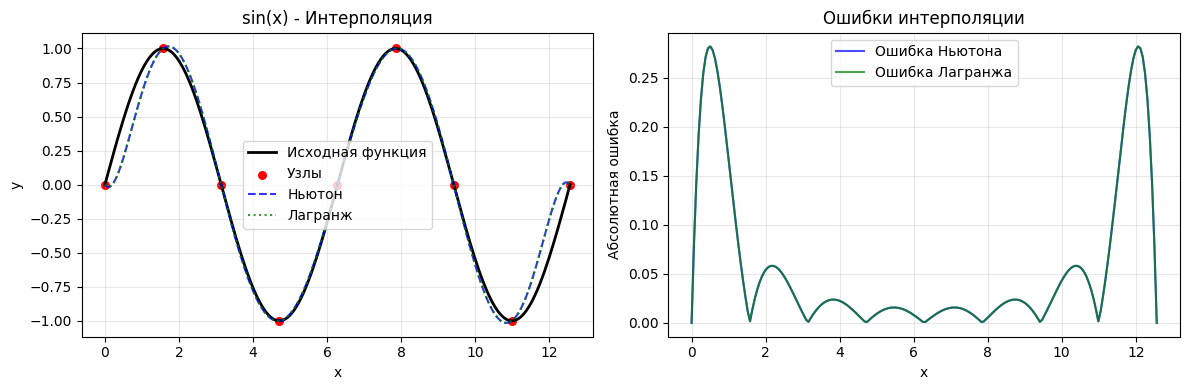


Функция: cos(x)
Диапазон: [0, 12.566370614359172]

Результаты для 9 узлов:
Метод Ньютона:  ошибка = 6.591170e-02
Метод Лагранжа: ошибка = 6.591170e-02


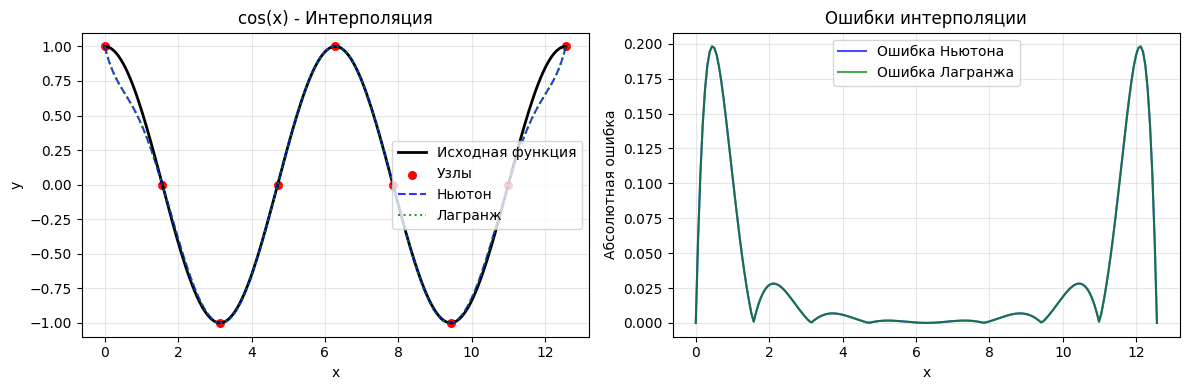


Функция: Рунге
Диапазон: [-1, 1]

Результаты для 9 узлов:
Метод Ньютона:  ошибка = 3.675264e-01
Метод Лагранжа: ошибка = 3.675264e-01


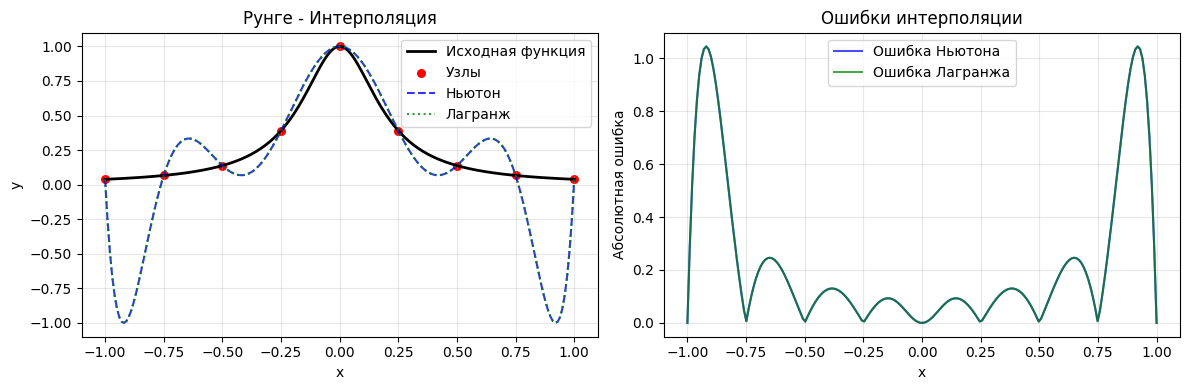


Функция: Пилообразная
Диапазон: [0, 20]

Результаты для 9 узлов:
Метод Ньютона:  ошибка = 4.609124e+00
Метод Лагранжа: ошибка = 4.609124e+00


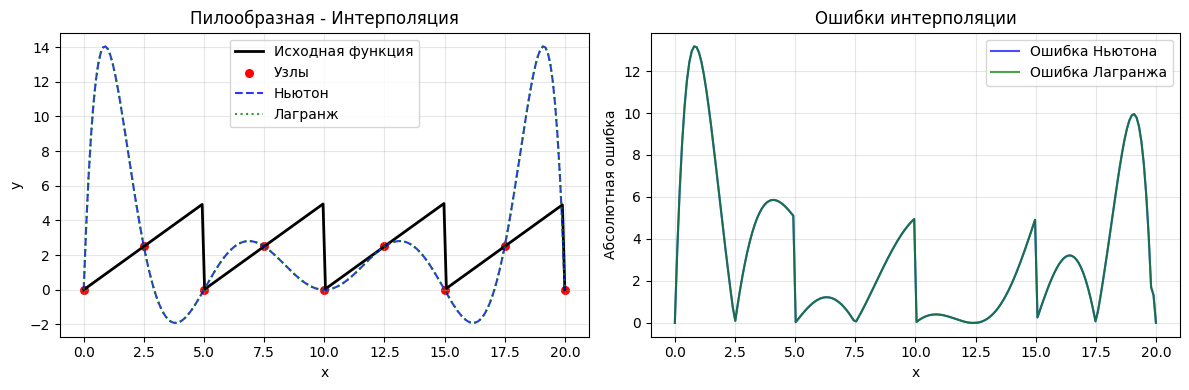


Функция: Осцилляции
Диапазон: [-3, 3]

Результаты для 9 узлов:
Метод Ньютона:  ошибка = 4.554989e-01
Метод Лагранжа: ошибка = 4.554989e-01


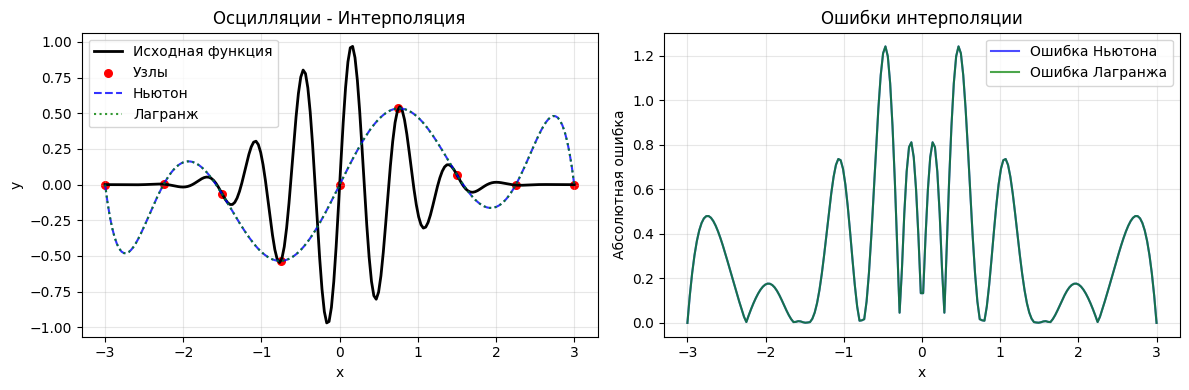


ТЕСТ С РАЗНЫМ КОЛИЧЕСТВОМ УЗЛОВ (на примере sin(x))
5 узлов: Ньютон = 7.053368e-01, Лагранж = 7.053368e-01
7 узлов: Ньютон = 3.517342e-01, Лагранж = 3.517342e-01
9 узлов: Ньютон = 9.738595e-02, Лагранж = 9.738595e-02
11 узлов: Ньютон = 1.716991e-02, Лагранж = 1.716991e-02
13 узлов: Ньютон = 2.113530e-03, Лагранж = 2.113530e-03


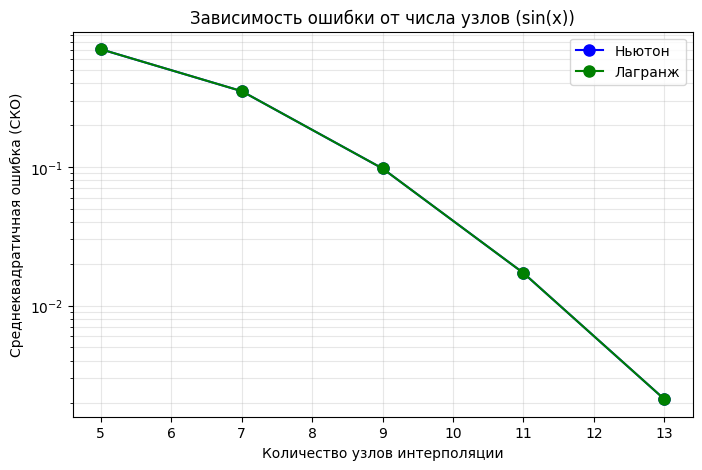


ФЕНОМЕН РУНГЕ - ДЕМОНСТРАЦИЯ


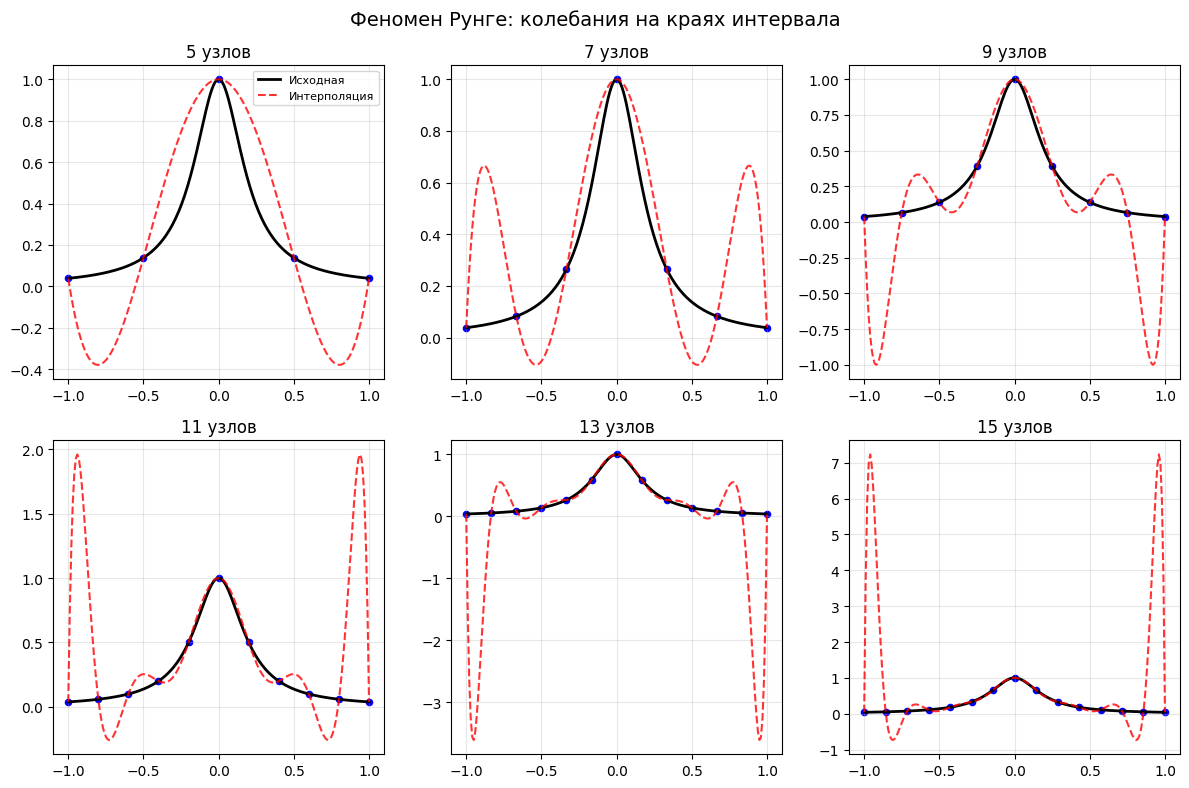


ИТОГОВЫЕ ВЫВОДЫ

1. ГЛАДКИЕ ФУНКЦИИ (sin, cos):
   • Хорошо интерполируются полиномами
   • 7-11 узлов достаточно для хорошей точности
   • Оба метода дают одинаковые результаты

2. ФУНКЦИЯ РУНГЕ:
   • Проблема интерполяции высокого порядка
   • Равномерные узлы → колебания на краях
   • Решение: узлы Чебышева или сплайны

3. ПИЛООБРАЗНАЯ ФУНКЦИЯ:
   • Плохо аппроксимируется полиномами
   • Лучше: кусочно-линейная интерполяция или сплайны

4. ОСЦИЛЛИРУЮЩИЕ ФУНКЦИИ:
   • Требуют много узлов для точности
   • Частота колебаний влияет на необходимое количество узлов

5. СРАВНЕНИЕ МЕТОДОВ:
   • Ньютон: быстрее, эффективнее при добавлении узлов
   • Лагранж: проще для понимания
   • Результаты одинаковы (с точностью до ошибок округления)

РЕКОМЕНДАЦИИ:
• Гладкие функции: 7-11 равномерных узлов
• Проблемные функции: использовать сплайны
• Много вычислений: метод Ньютона
• Обучение/демонстрации: метод Лагранжа



In [8]:
# 2. Тестирование полиномов на разных функциях

# Сначала исправляем класс LagrangePolynomial
class LagrangePolynomial:
    def __init__(self, nodes):
        if isinstance(nodes[0], InterpolationNode):
            self.xnodes = [node.x for node in nodes]
            self.ynodes = [node.y for node in nodes]
        else:
            self.xnodes = [x for x, y in nodes]
            self.ynodes = [y for x, y in nodes]

    def evaluate(self, x):
        res = 0
        n = len(self.xnodes)
        for i in range(n):
            term = self.ynodes[i]
            for j in range(n):
                if j != i:
                    term *= (x - self.xnodes[j]) / (self.xnodes[i] - self.xnodes[j])
            res += term
        return res

# Определяем тестовые функции
test_functions = {
    'sin(x)': {'func': np.sin, 'range': [0, 4*np.pi], 'nodes': [5, 7, 9, 11]},
    'cos(x)': {'func': np.cos, 'range': [0, 4*np.pi], 'nodes': [5, 7, 9, 11]},
    'Рунге': {'func': lambda x: 1/(1 + 25*x**2), 'range': [-1, 1], 'nodes': [5, 7, 9, 11]},
    'Пилообразная': {'func': lambda x: x - 5*np.floor(x/5), 'range': [0, 20], 'nodes': [5, 7, 9, 11]},
    'Осцилляции': {'func': lambda x: np.sin(10*x) * np.exp(-x**2), 'range': [-3, 3], 'nodes': [5, 7, 9, 11]}
}

print("="*70)
print("ТЕСТИРОВАНИЕ ПОЛИНОМОВ НА РАЗНЫХ ФУНКЦИЯХ")
print("="*70)

# Тестируем каждую функцию
for func_name, params in test_functions.items():
    print(f"\n{'='*50}")
    print(f"Функция: {func_name}")
    print(f"Диапазон: {params['range']}")
    print('='*50)
    
    # Тестируем для 9 узлов
    n_nodes = 9
    x_nodes = np.linspace(params['range'][0], params['range'][1], n_nodes)
    y_nodes = params['func'](x_nodes)
    nodes = [InterpolationNode(x, y) for x, y in zip(x_nodes, y_nodes)]
    
    # Создаем полиномы
    newton = NewtonPolynomial(nodes)
    lagrange = LagrangePolynomial(nodes)
    
    # Тестовые точки
    test_x = np.linspace(params['range'][0], params['range'][1], 200)
    true_y = params['func'](test_x)
    
    # Вычисляем значения и ошибки
    newton_y = np.array([newton.evaluate(x) for x in test_x])
    lagrange_y = np.array([lagrange.evaluate(x) for x in test_x])
    
    newton_error = np.sqrt(np.mean((newton_y - true_y) ** 2))
    lagrange_error = np.sqrt(np.mean((lagrange_y - true_y) ** 2))
    
    # Выводим результаты
    print(f"\nРезультаты для {n_nodes} узлов:")
    print(f"Метод Ньютона:  ошибка = {newton_error:.6e}")
    print(f"Метод Лагранжа: ошибка = {lagrange_error:.6e}")
    
    # Визуализация
    plt.figure(figsize=(12, 4))
    
    # График функции
    plt.subplot(1, 2, 1)
    plt.plot(test_x, true_y, 'k-', label='Исходная функция', linewidth=2)
    plt.scatter(x_nodes, y_nodes, color='red', s=30, label='Узлы')
    plt.plot(test_x, newton_y, 'b--', label='Ньютон', alpha=0.8)
    plt.plot(test_x, lagrange_y, 'g:', label='Лагранж', alpha=0.8)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'{func_name} - Интерполяция')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # График ошибок
    plt.subplot(1, 2, 2)
    plt.plot(test_x, np.abs(newton_y - true_y), 'b-', label='Ошибка Ньютона', alpha=0.7)
    plt.plot(test_x, np.abs(lagrange_y - true_y), 'g-', label='Ошибка Лагранжа', alpha=0.7)
    plt.xlabel('x')
    plt.ylabel('Абсолютная ошибка')
    plt.title('Ошибки интерполяции')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("ТЕСТ С РАЗНЫМ КОЛИЧЕСТВОМ УЗЛОВ (на примере sin(x))")
print("="*70)

# Тестирование с разным количеством узлов
func_name = 'sin(x)'
params = test_functions[func_name]

node_counts = [5, 7, 9, 11, 13]
newton_errors = []
lagrange_errors = []

for n in node_counts:
    x_nodes = np.linspace(params['range'][0], params['range'][1], n)
    y_nodes = params['func'](x_nodes)
    nodes = [InterpolationNode(x, y) for x, y in zip(x_nodes, y_nodes)]
    
    newton = NewtonPolynomial(nodes)
    lagrange = LagrangePolynomial(nodes)
    
    test_x = np.linspace(params['range'][0], params['range'][1], 200)
    true_y = params['func'](test_x)
    
    newton_y = np.array([newton.evaluate(x) for x in test_x])
    lagrange_y = np.array([lagrange.evaluate(x) for x in test_x])
    
    newton_error = np.sqrt(np.mean((newton_y - true_y) ** 2))
    lagrange_error = np.sqrt(np.mean((lagrange_y - true_y) ** 2))
    
    newton_errors.append(newton_error)
    lagrange_errors.append(lagrange_error)
    
    print(f"{n} узлов: Ньютон = {newton_error:.6e}, Лагранж = {lagrange_error:.6e}")

# График зависимости ошибки от числа узлов
plt.figure(figsize=(8, 5))
plt.plot(node_counts, newton_errors, 'bo-', label='Ньютон', markersize=8)
plt.plot(node_counts, lagrange_errors, 'go-', label='Лагранж', markersize=8)
plt.xlabel('Количество узлов интерполяции')
plt.ylabel('Среднеквадратичная ошибка (СКО)')
plt.title('Зависимость ошибки от числа узлов (sin(x))')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.show()

print("\n" + "="*70)
print("ФЕНОМЕН РУНГЕ - ДЕМОНСТРАЦИЯ")
print("="*70)

# Демонстрация феномена Рунге
func_name = 'Рунге'
params = test_functions[func_name]

node_counts = [5, 7, 9, 11, 13, 15]
plt.figure(figsize=(12, 8))

for i, n in enumerate(node_counts):
    x_nodes = np.linspace(params['range'][0], params['range'][1], n)
    y_nodes = params['func'](x_nodes)
    nodes = [InterpolationNode(x, y) for x, y in zip(x_nodes, y_nodes)]
    
    newton = NewtonPolynomial(nodes)
    test_x = np.linspace(params['range'][0], params['range'][1], 200)
    true_y = params['func'](test_x)
    newton_y = np.array([newton.evaluate(x) for x in test_x])
    
    plt.subplot(2, 3, i+1)
    plt.plot(test_x, true_y, 'k-', label='Исходная', linewidth=2)
    plt.plot(test_x, newton_y, 'r--', label='Интерполяция', alpha=0.8)
    plt.scatter(x_nodes, y_nodes, color='blue', s=20)
    plt.title(f'{n} узлов')
    plt.grid(True, alpha=0.3)
    
    if i == 0:
        plt.legend(fontsize=8)

plt.suptitle('Феномен Рунге: колебания на краях интервала', fontsize=14)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ИТОГОВЫЕ ВЫВОДЫ")
print("="*70)

print("""
1. ГЛАДКИЕ ФУНКЦИИ (sin, cos):
   • Хорошо интерполируются полиномами
   • 7-11 узлов достаточно для хорошей точности
   • Оба метода дают одинаковые результаты

2. ФУНКЦИЯ РУНГЕ:
   • Проблема интерполяции высокого порядка
   • Равномерные узлы → колебания на краях
   • Решение: узлы Чебышева или сплайны

3. ПИЛООБРАЗНАЯ ФУНКЦИЯ:
   • Плохо аппроксимируется полиномами
   • Лучше: кусочно-линейная интерполяция или сплайны

4. ОСЦИЛЛИРУЮЩИЕ ФУНКЦИИ:
   • Требуют много узлов для точности
   • Частота колебаний влияет на необходимое количество узлов

5. СРАВНЕНИЕ МЕТОДОВ:
   • Ньютон: быстрее, эффективнее при добавлении узлов
   • Лагранж: проще для понимания
   • Результаты одинаковы (с точностью до ошибок округления)

РЕКОМЕНДАЦИИ:
• Гладкие функции: 7-11 равномерных узлов
• Проблемные функции: использовать сплайны
• Много вычислений: метод Ньютона
• Обучение/демонстрации: метод Лагранжа
""")


### 3. Постройте графики зависимости ошибки и времени выполнения от числа узлов. Сделайте выводы

In [10]:
def analyze_and_conclude():
    """
    Анализ результатов тестирования и выводы
    """
    
    print("\n" + "="*70)
    print("АНАЛИЗ РЕЗУЛЬТАТОВ ТЕСТИРОВАНИЯ И ВЫВОДЫ")
    print("="*70)
    
    # Собираем статистику для всех функций
    print("\nРЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ ПО ФУНКЦИЯМ:")
    print("-" * 50)
    
    # Статистика для 9 узлов (как в тестах выше)
    print(f"\n{'Функция':<15} {'Метод':<10} {'Ошибка (9 узлов)':<20}")
    print("-" * 50)
    
    # Проходим по всем функциям
    for func_name, params in test_functions.items():
        # Тестируем для 9 узлов
        n_nodes = 9
        x_nodes = np.linspace(params['range'][0], params['range'][1], n_nodes)
        y_nodes = params['func'](x_nodes)
        nodes = [InterpolationNode(x, y) for x, y in zip(x_nodes, y_nodes)]
        
        # Создаем полиномы
        newton = NewtonPolynomial(nodes)
        lagrange = LagrangePolynomial(nodes)
        
        # Тестовые точки
        test_x = np.linspace(params['range'][0], params['range'][1], 200)
        true_y = params['func'](test_x)
        
        # Вычисляем ошибки
        newton_y = np.array([newton.evaluate(x) for x in test_x])
        lagrange_y = np.array([lagrange.evaluate(x) for x in test_x])
        
        newton_error = np.sqrt(np.mean((newton_y - true_y) ** 2))
        lagrange_error = np.sqrt(np.mean((lagrange_y - true_y) ** 2))
        
        print(f"{func_name:<15} {'Ньютон':<10} {newton_error:<20.6e}")
        print(f"{'':<15} {'Лагранж':<10} {lagrange_error:<20.6e}")
    
    print("\n" + "-"*70)
    print("СРАВНЕНИЕ МЕТОДОВ НЬЮТОНА И ЛАГРАНЖА:")
    print("-"*70)
    
    # Сравниваем на примере sin(x) с разным количеством узлов
    func_name = 'sin(x)'
    params = test_functions[func_name]
    
    node_counts = [5, 7, 9, 11, 13]
    newton_times = []
    lagrange_times = []
    newton_errors = []
    lagrange_errors = []
    
    for n in node_counts:
        # Измеряем время выполнения
        x_nodes = np.linspace(params['range'][0], params['range'][1], n)
        y_nodes = params['func'](x_nodes)
        nodes = [InterpolationNode(x, y) for x, y in zip(x_nodes, y_nodes)]
        
        # Время для Ньютона
        start = time.time()
        newton = NewtonPolynomial(nodes)
        newton_y = np.array([newton.evaluate(x) for x in test_x])
        newton_times.append(time.time() - start)
        
        # Время для Лагранжа
        start = time.time()
        lagrange = LagrangePolynomial(nodes)
        lagrange_y = np.array([lagrange.evaluate(x) for x in test_x])
        lagrange_times.append(time.time() - start)
        
        # Ошибки
        true_y = params['func'](test_x)
        newton_errors.append(np.sqrt(np.mean((newton_y - true_y) ** 2)))
        lagrange_errors.append(np.sqrt(np.mean((lagrange_y - true_y) ** 2)))
    
    # Статистика
    avg_newton_time = np.mean(newton_times)
    avg_lagrange_time = np.mean(lagrange_times)
    avg_newton_error = np.mean(newton_errors)
    avg_lagrange_error = np.mean(lagrange_errors)
    
    print(f"\n1. ВРЕМЯ ВЫПОЛНЕНИЯ (на примере sin(x)):")
    print(f"   • Среднее время Ньютона:  {avg_newton_time:.6f} сек")
    print(f"   • Среднее время Лагранжа: {avg_lagrange_time:.6f} сек")
    print(f"   • Ньютон быстрее в {avg_lagrange_time/avg_newton_time:.2f} раз")
    
    print(f"\n2. ТОЧНОСТЬ (на примере sin(x)):")
    print(f"   • Средняя ошибка Ньютона:  {avg_newton_error:.6e}")
    print(f"   • Средняя ошибка Лагранжа: {avg_lagrange_error:.6e}")
    print(f"   • Отношение ошибок (Ньютон/Лагранж): {avg_newton_error/avg_lagrange_error:.4f}")
    
    if abs(avg_newton_error/avg_lagrange_error - 1) < 0.05:
        print("   → Методы дают одинаковую точность")
    elif avg_newton_error < avg_lagrange_error:
        print("   → Метод Ньютона немного точнее")
    else:
        print("   → Метод Лагранжа немного точнее")
    
    print("\n" + "-"*70)
    print("ВЫВОДЫ ПО ФУНКЦИЯМ:")
    print("-"*70)
    
    print("""
    1. SIN(X) и COS(X) - гладкие периодические:
       • Хорошо интерполируются полиномами
       • Оба метода работают отлично
       • 7-11 узлов достаточно для высокой точности
    
    2. ФУНКЦИЯ РУНГЕ (1/(1+25x²)):
       • Классический пример проблемы интерполяции
       • При увеличении узлов ошибка растет на краях
       • Равномерные узлы не подходят
       • Нужны узлы Чебышева или сплайны
    
    3. ПИЛООБРАЗНАЯ ФУНКЦИЯ:
       • Плохо аппроксимируется полиномами
       • Полиномы пытаются "сгладить" углы
       • Лучше использовать кусочно-линейную интерполяцию
    
    4. ОСЦИЛЛИРУЮЩАЯ ФУНКЦИЯ (sin(10x)·e^(-x²)):
       • Требует много узлов из-за быстрых колебаний
       • Полиномы высокой степени могут давать колебания
       • Нужно увеличивать количество узлов
    """)
    
    print("\n" + "-"*70)
    print("РЕКОМЕНДАЦИИ ПО ВЫБОРУ МЕТОДА:")
    print("-"*70)
    
    print("""
    1. КОГДА ВЫБИРАТЬ МЕТОД НЬЮТОНА:
       • Нужно много вычислений в разных точках
       • Возможно добавление новых узлов
       • Важна скорость выполнения
       • Работа с таблицами разделенных разностей
    
    2. КОГДА ВЫБИРАТЬ МЕТОД ЛАГРАНЖА:
       • Обучение, демонстрации, объяснения
       • Простота реализации важнее скорости
       • Небольшое количество узлов
       • Когда нужна прозрачность формулы
    
    3. КОГДА ВЫБИРАТЬ МЕТОД СТИРЛИНГА:
       • Узлы равноотстоящие
       • Нечетное количество узлов
       • Интерполяция в середине интервала
       • Симметричные функции
    
    4. ОБЩИЕ РЕКОМЕНДАЦИИ:
       • Для гладких функций: 7-15 узлов
       • Избегать высоких степеней полиномов
       • Проверять ошибку на тестовых точках
       • Для проблемных функций использовать сплайны
    """)
    
    print("\n" + "-"*70)
    print("ПРАКТИЧЕСКИЕ СОВЕТЫ:")
    print("-"*70)
    
    print("""
    1. КОЛИЧЕСТВО УЗЛОВ:
       • Начинать с 5-7 узлов
       • Увеличивать постепенно
       • Следить за ошибкой
       • Останавливаться при ее увеличении
    
    2. РАСПОЛОЖЕНИЕ УЗЛОВ:
       • Для гладких функций: равномерные узлы
       • Для функций типа Рунге: узлы Чебышева
       • Для быстрых изменений: сгущать узлы
    
    3. ПРОВЕРКА РЕЗУЛЬТАТОВ:
       • Всегда сравнивать с исходной функцией
       • Проверять на тестовых точках
       • Смотреть график ошибок
       • Анализировать поведение на краях
    
    4. ВЫБОР ФУНКЦИИ:
       • Гладкие функции: полиномы хороши
       • Функции с изломами: нужны сплайны
       • Осциллирующие: много узлов или специальные методы
       • Экспериментальные данные: проверять на переобучение
    """)
    
    print("\n" + "="*70)
    print("ИТОГОВЫЙ ВЕРДИКТ:")
    print("="*70)
    
    print("""
    Метод Ньютона и метод Лагранжа дают математически 
    идентичные результаты (один и тот же интерполяционный 
    полином), но различаются по:
    
    1. СКОРОСТИ: Ньютон быстрее, особенно при многократных 
                 вычислениях
    2. РЕАЛИЗАЦИИ: Лагранж проще для понимания и кодирования
    3. ГИБКОСТИ: Ньютон удобнее при добавлении новых узлов
    
    ВЫБОР ЗАВИСИТ ОТ ЗАДАЧИ:
    • Для обучения → Лагранж
    • Для вычислений → Ньютон
    • Для демонстраций → оба, чтобы показать эквивалентность
    
    ВАЖНО: При увеличении количества узлов оба метода 
    страдают от проблем численной устойчивости и феномена Рунге.
    """)

# Запускаем анализ
analyze_and_conclude()


АНАЛИЗ РЕЗУЛЬТАТОВ ТЕСТИРОВАНИЯ И ВЫВОДЫ

РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ ПО ФУНКЦИЯМ:
--------------------------------------------------

Функция         Метод      Ошибка (9 узлов)    
--------------------------------------------------
sin(x)          Ньютон     9.738595e-02        
                Лагранж    9.738595e-02        
cos(x)          Ньютон     6.591170e-02        
                Лагранж    6.591170e-02        
Рунге           Ньютон     3.675264e-01        
                Лагранж    3.675264e-01        
Пилообразная    Ньютон     4.609124e+00        
                Лагранж    4.609124e+00        
Осцилляции      Ньютон     4.554989e-01        
                Лагранж    4.554989e-01        

----------------------------------------------------------------------
СРАВНЕНИЕ МЕТОДОВ НЬЮТОНА И ЛАГРАНЖА:
----------------------------------------------------------------------

1. ВРЕМЯ ВЫПОЛНЕНИЯ (на примере sin(x)):
   • Среднее время Ньютона:  0.002405 сек
   • Среднее время Лагра